# Biodiversity Intactness Index Change in Phoenix, AZ
**Author**: Vedika Shirtekar

**Repository**: https://github.com/vedikaS-byte/biodiversity-analysis

## About

### Purpose
Maricopa County, the fourth most populous county in the United States, is home to more than half of Arizona's residents and contains the state capital, Phoenix. As of 2022, the county had a population of 4.5 million people and was listed as the fastest-growing county in the U.S., adding nearly 56,000 residents between July 2021 and 2022 (Maricopa County, n.d.). This rapid population growth has contributed to the most significant increase in developed land in the county since at least 2001 (Levitt & Eng, 2021). Consequently, expanding urban sprawl has raised concerns about impacts on biodiversity and ecosystem health in the surrounding areas.



This assignment investigates urban sprawl impacts on diversity by analyzing Biodiversity Intactness Index (BII) values in the Phoenix county subdivision area for 2017 and 2020. The analysis highlights how urban growth corresponds with changes in biodiversity over time, providing insight into the ecological consequences of expanding urban landscapes. The final output consists of a map illustrating changes in BII over time across the Phoenix metropolitan area, highlighting areas of biodiversity loss.

### Highlights
Three key highlights were identified in the analysis: 

1. **Load a raster from a catalog of diverse geospatial datasets to access standardized environmental information for the study area of interest.**

2. **Create a mask by selecting raster cells that meet a specific condition (ex. BII ≥ .75 in a select year).**

3. **Ensure the shapefile and raster share the same coordinate reference system (CRS) to prevent misalignment and enable accurate spatial calculations.**

### Data Description 
The Biodiversity Intactness Index (BII) is a global dataset that quantifies changes in biodiversity using species abundance information for plants, fungi, and animals [Natural History Museum (n.d.)](https://www.nhm.ac.uk/our-science/services/data/biodiversity-intactness-index.html). For this analysis, BII raster layers from 2017 and 2020 were obtained from the `io-biodiversity` collection in the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity) and clipped to the Phoenix subdivision. The index captures how terrestrial ecosystems respond to human pressures such as land-use change and increased intensity of development, providing insight into the degree to which local biodiversity remains intact over time.



The U.S. Census Bureau provides public access to geographic boundary data through its [TIGER/Line® Shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php) database. For this project, the [2025 Arizona County Subdivisions](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2025&layergroup=County+Subdivisions) layer was downloaded to obtain county-level boundary shapefiles representing Arizona’s administrative divisions as of 2025.


### Data References
[1] Microsoft Planetary Computer. *Biodiversity Intactness Index (BII) Time Series*. [Dataset] Microsoft Planetary Computer. Accessed December 3, from
https://planetarycomputer.microsoft.com/dataset/io-biodiversity


[2] United States Census Bureau. *2025 TIGER/Line® Shapefiles: County Subdivisions* [Dataset]. U.S. Census Bureau. Accessed December 3, 2025, from 
https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2025&layergroup=County+Subdivisions

## Import and Read in Data
Import the neccessary libraries and read in the County shapefiles.  

In [1]:
# Import necessary libraries along with defined abbreviations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl # Extract same color from color palette
import geopandas as gpd 
import xarray as xarray
import contextily as ctx # Access basemaps
import rioxarray as rioxr
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

In [2]:
# Set up display options when looking at data frames
pd.set_option("display.max.columns", None)

# Establish file path to read in shapefile
az_fp = os.path.join("data", "tl_2025_04_cousub", 
                        "tl_2025_04_cousub.shp")
az = gpd.read_file(az_fp)

## Data Exploration

### Exploring the Phoenix Subdivision Shapefile
In the cells below, conduct an initial exploratory review of the `phoenix` shapefile to identify its main properties. Then, write a short summary highlighting its key spatial and attribute characteristics.

Extract the geometry for Phoenix in the Arizona county subdivisions shapefile and observe the first row to determine whether the correct geometry has been selected.

In [3]:
# Isolate for just Phoenix (Maricopa County)
phoenix = az[az["NAME"] == "Phoenix"]

In [4]:
# View the first few rows
phoenix.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
69,04,013,92601,01934968,0401392601,0600000US0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,S,2806469278,9424955,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

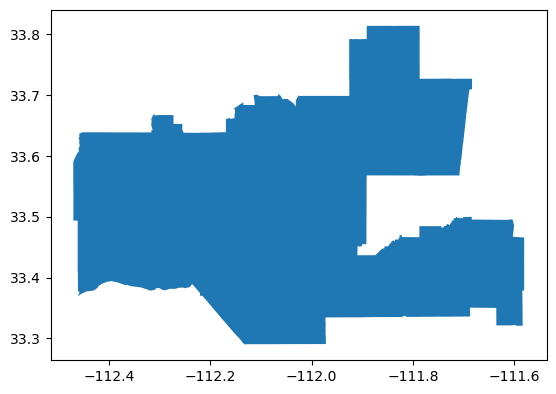

In [5]:
# Plot to confirm correct geometry
phoenix.plot()

Explore data types, dimensions, and additional attributes of `phoenix`. Identify the coordinate reference system (CRS) of `phoenix` as well.


In [6]:
# Explore data types, dimensions, and additional attributes
phoenix.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1 entries, 69 to 69
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1 non-null      object  
 1   COUNTYFP  1 non-null      object  
 2   COUSUBFP  1 non-null      object  
 3   COUSUBNS  1 non-null      object  
 4   GEOID     1 non-null      object  
 5   GEOIDFQ   1 non-null      object  
 6   NAME      1 non-null      object  
 7   NAMELSAD  1 non-null      object  
 8   LSAD      1 non-null      object  
 9   CLASSFP   1 non-null      object  
 10  MTFCC     1 non-null      object  
 11  FUNCSTAT  1 non-null      object  
 12  ALAND     1 non-null      int64   
 13  AWATER    1 non-null      int64   
 14  INTPTLAT  1 non-null      object  
 15  INTPTLON  1 non-null      object  
 16  geometry  1 non-null      geometry
dtypes: geometry(1), int64(2), object(14)
memory usage: 144.0+ bytes


In [7]:
# Check the projected CRS
print(f"CRS of Phoenix shapefile: {phoenix.crs.name} ({phoenix.crs.to_epsg()}).") 

CRS of Phoenix shapefile: NAD83 (4269).


Create an exploratory map of Phoenix within Maricopa County. Use the `contextily` library to add a basemap, providing geographic context for the Phoenix metropolitan area.

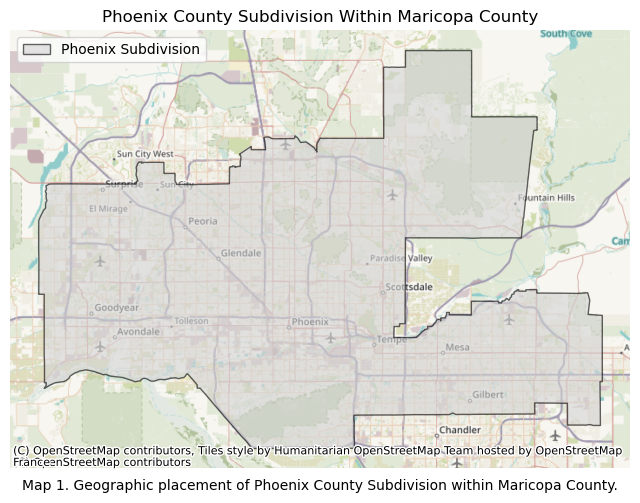

In [48]:
# Map of Phoenix with basemap
fig, ax = plt.subplots(figsize = (8,8))

# Project Phoenix to correct CRS for preferred basemap
phoenix  = phoenix.to_crs(3857)

# Plot shapefile
phoenix.plot(ax= ax, edgecolor = "black", facecolor = "lightgrey", alpha = .6)

# Add appropriate basemap
ctx.add_basemap(ax, source = ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
)

# Set axis off
ax.set_axis_off()

# Set title
ax.set_title("Phoenix County Subdivision Within Maricopa County")

# Create patch for reference in legend
phoenix_outline = mpatches.Patch(facecolor = "lightgrey", edgecolor = "black", alpha = .6, label= "Phoenix Subdivision")
ax.legend(handles = [phoenix_outline], loc = "upper left")

# Set a
ax.annotate("Map 1. Geographic placement of Phoenix County Subdivision within Maricopa County.",
            xy =(0.5, -0.05), # Position relative to axis (off from center, push up)
            xycoords ="axes fraction", # Recognize coordinate placement as fraction of axis size
            ha ="center", # Center
            fontsize = 10 # Font size
)
# Call plot
plt.show()

The `phoenix` shapefile is a `geopandas.GeoDataFrame` containing a single observation with 16 variables of types `object`, `int64`, and `geometry`. Its CRS is WGS 84 (EPSG:4326). Based on the accompanying figure, the subdivision covers a large area and includes major cities such as Glendale, Phoenix, Scottsdale, and Mesa.

### Exploring the `io-biodiversity` Microsoft Planetary Computer Catalog
Rasters can be accessed directly from an online catalog database. To open the catalog, use `Client.open()` and provide the URL for the catalog directory. When opening the catalog, a modifier such as `modifier=planetary_computer.sign_inplace` can be specified to configure access to the dataset. To extract the desired dataset, use the collection code "io-biodiversity" to retrieve the collections associated with the BII.

In [9]:
# Open MPC STAC Catelog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace)

# Pull out BII collection
bii_collection = catalog.get_child("io-biodiversity")
bii_collection

<CollectionClient id=io-biodiversity>

**Include a brief summary of the `io-biodiversity `collection description.**

The `io-biodiversity` collection contains datasets that provide 100-meter resolution gridded estimates of terrestrial Biodiversity Intactness for the period 2017–2020. According to the STAC description, a persistent limitation of spatial products is that they are often outdated by the time they reach practitioners and policy-makers. As such, the datasets in this STAC Collection build on previous Biodiversity Intactness research and use analyses derived from the PREDICTS database to improve and update existing estimates.






## Extracting BII Rasters from the Microsoft Planetary Computer Catalog

Raster files retrieved directly from an online catalog can be opened through an item-based search. 

It is necessary to define a bounding box as a reference raster for geospatial operations, such as clipping. Here, define the bounding box with the coordinates: [-112.826843, 32.974108, -111.184387, 33.863574].

In [10]:
# Define bounding box
phoenix_bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

Search the BII collection within the Phoenix bounding box for 2017 and 2020. Then, select the first STAC item from each year's results to use in the analysis.

In [11]:
# Search for BII collection within bbox
search_2017 = catalog.search(
    collections = ["io-biodiversity"], 
    bbox = phoenix_bbox, 
    datetime = "2017-01-01/2017-12-31" # Grab range for years
)


search_2020 = catalog.search(
    collections = ["io-biodiversity"], 
    bbox = phoenix_bbox, 
    datetime = "2020-01-01/2020-12-31" # Grab range for year
)

# Return first STAC item from search year result
items_2017 = list(search_2017.items())[0]
items_2020 = list(search_2020.items())[0]

Once the first item is identified for each year, the raster can be opened. Use `assets.keys()` to view the available assets and select the appropriate key as a reference in `open_rasterio` via the `rioxarray` accessor. Repeat this process to open both the 2017 and 2020 rasters, and use `squeeze()` to drop the singular band so that each raster has the correct dimensions.

In [12]:
# Determine reference term for assests
items_2017.assets.keys()

dict_keys(['data', 'tilejson', 'rendered_preview'])

In [13]:
# Open raster for 2017 
bii_2017 = rioxr.open_rasterio(items_2017.assets['data'].href)

# Squeeze to remove length 1 dimension (band)
bii_2017 = bii_2017.squeeze().drop_vars('band')

In [14]:
# Open raster for 2020
bii_2020 = rioxr.open_rasterio(items_2020.assets['data'].href)

# Squeeze to remove length 1 dimension (band)
bii_2020 = bii_2020.squeeze().drop_vars('band')

## Clipping the Phoenix Shapefile to the BII Rasters

Ensure that the CRS of the raster (`xarray.DataArray`) and the shapefile match to prevent misalignment.

In [15]:
# Do the bii_2017 and bii_2020 raster CRS match? 
print(f"Do the bii_2017 and bii_2020 raster CRS match? Answer: {bii_2017.rio.crs == bii_2020.rio.crs}")

Do the bii_2017 and bii_2020 raster CRS match? Answer: True


In [16]:
# Perform check with conditional statements
print(f" The Phoenix shapefile CRS is currently: {phoenix.crs.to_epsg()}")

# Project phoenix to match CRS of bii_2017 raster
if (phoenix.crs != bii_2017.rio.crs):
    phoenix = phoenix.to_crs(bii_2017.rio.crs)
    
print(f" The 2017 BII raster CRS is currently: {bii_2017.rio.crs.to_epsg()}")

print(f" The Phoenix shapefile CRS is now: {phoenix.crs.to_epsg()}")

 The Phoenix shapefile CRS is currently: 3857
 The 2017 BII raster CRS is currently: 4326
 The Phoenix shapefile CRS is now: 4326


Clip both the 2017 and 2020 BII rasters to the Phoenix subdivision geometry, ensuring both align with the shapefile CRS. Plot the clipped 2017 and 2020 rasters to visualize the specified bounded area of interest

In [17]:
# Clip each raster to the phoenix bounding box
bii_2017_clip = bii_2017.rio.clip(phoenix.geometry, phoenix.crs)

In [18]:
# Clip each raster to the phoenix bounding box
bii_2020_clip = bii_2020.rio.clip(phoenix.geometry, phoenix.crs)

Text(0.5, 1.0, 'Clipped BII Raster (2017)')

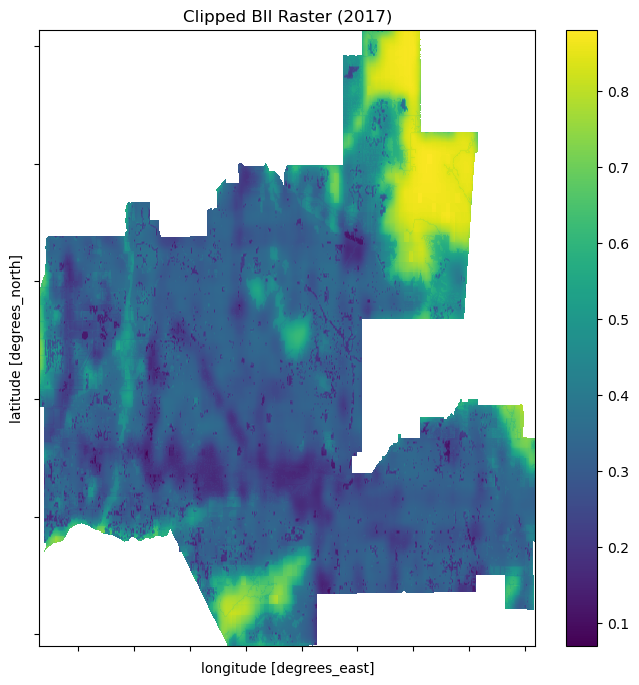

In [28]:
# One band is expected since one index
fig, ax = plt.subplots(figsize = (8,8))
bii_2017_clip.plot(ax=ax)

ax.set_xticklabels([]) # Turn off x axis
ax.set_yticklabels([])  # Turn off y axis

# Set title
ax.set_title("Clipped BII Raster (2017)")

Text(0.5, 1.0, 'Clipped BII Raster (2020)')

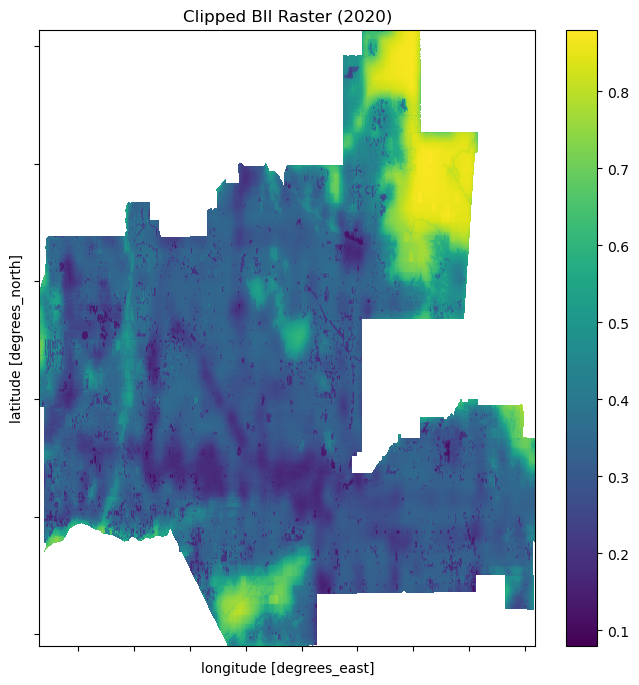

In [27]:
# One band is expected since one index
fig, ax = plt.subplots(figsize = (8,8))
bii_2020_clip.plot(ax=ax)

# Turn of axis labels
ax.set_xticklabels([]) # Turn off x axis
ax.set_yticklabels([])  # Turn off y axis

# Set title 
ax.set_title("Clipped BII Raster (2020)")

## Identifying Temporal Losses in BII Area 
To identify losses in BII area between 2017 and 2020, create spatial masks for raster pixels with BII values greater than or equal to 0.75 to isolate areas of high biodiversity. 

In [21]:
# Identify B11 values exceeding .75
exceed_2017 = bii_2017_clip >= .75 # T if exceeded, F is not
exceed_2020 = bii_2020_clip >= .75  # T if exceeded, F is not

Create binary masks to isolate valid (`isnull()`) pixels in the 2017 and 2020 BII rasters.

In [22]:
# Create masks containing only valid (non-null) pixels in each year raster
non_null_mask_2017 = (~bii_2017_clip.isnull()) # "~" refers to conditional (assign true of false if empty/non empty)

non_null_mask_2020 = (~bii_2020_clip.isnull()) # "~" refers to conditional (assign true of false if empty/non empty)

Utilize these masks to count the total number of pixels with data in the Phoenix area using `sum()`. Then, calculate the percentage of pixels with BII values greater than or equal to 0.75 for each year. Finally, compute the percent change between 2017 and 2020 to quantify how the area of high biodiversity intactness has increased or decreased over time.

In [23]:
# Calculate percent area (# exceeded/total pixels) per year
perc_2017 = (exceed_2017.sum().item() # Count # of pixels where bii >= .75
             / 
             non_null_mask_2017.sum().item() # Count total non-empty pixels in phoenix
            ) * 100 

perc_2020 = (exceed_2020.sum().item() # Count # of pixels where bii >= .75
             / 
             non_null_mask_2020.sum().item() # Count total non-empty pixels in phoenix
            ) * 100 

In [24]:
# Determine the percent of area >= .75 per year
print(f"2017 BII area ≥ .75 is : {round(perc_2017,2)}%")
print(f"2020 BII area ≥ .75 is : {round(perc_2020,2)}%")

# Calculate the percent change between both years
print(f"Percent change in area >= .75 between 2017 and 2020: {round(perc_2020-perc_2017,2)}%")

2017 BII that includes or exceeds .75 is : 7.13%
2020 BII that includes or exceeds .75 is : 6.49%
Percent change in area >= .75 between 2017 and 2020: -0.63%


Create a difference mask by comparing the two boolean rasters so that pixels are marked `True` only when BII status changes between years, creating a binary outcome (one year is assigned `1` if `True`, and the other is assigned `0` if `False`). Then, include only the changed pixels and set all unchanged values to NaN to clearly visualize biodiversity loss.

In [25]:
# Create a difference mask to identify where status changed between two years
diff_mask = exceed_2017 ^ exceed_2020

# Include only changed pixels and set others to NaN
loss_numeric = diff_mask.where(diff_mask, other = np.nan)

Visualize the area losses in an exploratory map, along with a reflection of observable trends.

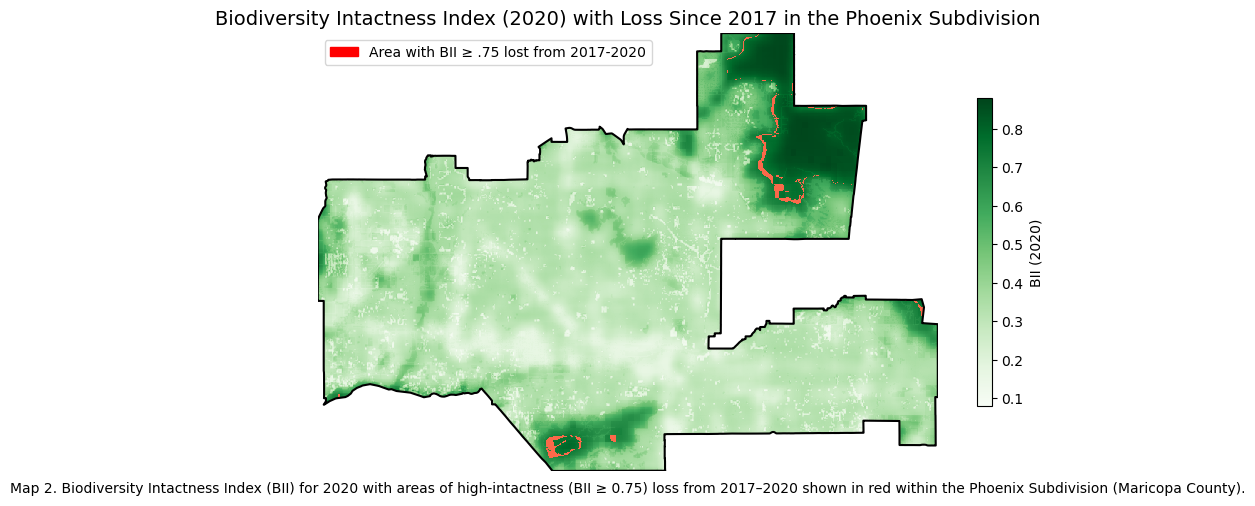

In [47]:
# Define figure and axis
fig, ax = plt.subplots(figsize=(10,10))

# Plot clipped bii_2020
bii_2020_clip.plot(
    ax=ax,
    cmap="Greens",
    add_colorbar=True, 
    cbar_kwargs = {"shrink":.4, "label": "BII (2020)"} # Shrink and label color bar
)

# Plot numerized area loss (NaN not included)
loss_numeric.plot(
    ax=ax,
    cmap= "Reds",
    add_colorbar=False
)

# Define patch for legend
loss_patch = mpatches.Patch(color = "red", label = "Area with BII ≥ .75 lost from 2017-2020")
ax.legend(handles = [loss_patch], loc = "upper left")

# Establish Phoenix boundary for reference
phoenix.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

#Establish title
ax.set_title("Biodiversity Intactness Index (2020) with Loss Since 2017 in the Phoenix Subdivision", fontsize=14)

# Turn off axis
ax.set_axis_off()

# Set a caption with annotate()
ax.annotate("Map 2. Biodiversity Intactness Index (BII) for 2020 with areas of high-intactness (BII ≥ 0.75) loss from 2017–2020 shown in red within the Phoenix Subdivision.",
            xy =(0.5, -0.05), # Position relative to axis (off from center, push up)
            xycoords ="axes fraction", # Recognize coordinate placement as fraction of axis size
            ha ="center", # Center
            fontsize = 10 # Font size
)

plt.show()

In the figure, there are noticeable losses of high-biodiversity (high-intactness) areas occurring mainly south of Phoenix and in the northeastern portion of Maricopa County. Approximately 7.13% of forested land in the county was classified as high-biodiversity in 2017, decreasing to 6.48% in 2020. This represents an estimated decline of 0.63% in high-intactness areas (BII ≥ 0.75) within the Phoenix subdivision (Maricopa County) over this period, as observed in Map 2. High-biodiversity loss was most obvious in forested regions, shown by the dark green areas in Map 1. As development expands in Maricopa County, forested areas should be monitored and protected to better assess and reduce impacts on biodiversity loss.